# CNN helicity classifier 

In [2]:
# import tensorflow as tf
# print(tf.config.experimental.list_physical_devices('GPU'))
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

In [6]:
print(tf.__version__)

2.6.0


In [7]:
image_train_path=r"data/train_images/"

one_image = Image.open(image_train_path+"/hel_minus/jetskyimg_250.png", "r")

#image_sequence = one_image.getdata()
image_array = np.array(one_image)
image_array.shape

(960, 1280, 4)

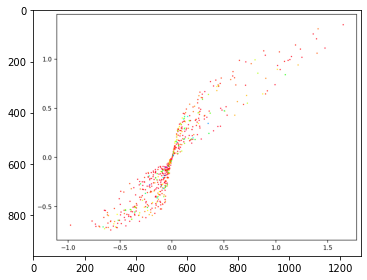

In [8]:

plt.imshow(image_array)
plt.tight_layout()
plt.show()

<font color='blue'><font size=5> Building a classifier for three classes of helicity, minus, zero, plus.</font>

## Data preparation

This is a nice tutorial to follow:
https://keras.io/examples/vision/image_classification_from_scratch/

In [9]:
image_size = (180, 180)
batch_size = 32
interpolation="bilinear" #String, the interpolation method used when resizing images. 
# Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.
seed=1337 # Optional random seed for shuffling and transformations.

data_train= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
    interpolation=interpolation,
    follow_links=False
)

data_val= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
    interpolation=interpolation,
    follow_links=False
)

Found 900 files belonging to 3 classes.
Using 720 files for training.
Metal device set to: Apple M1 Pro
Found 900 files belonging to 3 classes.
Using 180 files for validation.


2021-10-27 16:35:53.964714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-27 16:35:53.964923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2021-10-27 16:35:56.876894: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-27 16:35:56.877097: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-27 16:36:07.561183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 51 of 256
2021-10-27 16:36:18.056376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 117 of 256
2021-10-27 16:36:27.289677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 176 of 256
2021-10-27 16:36:37.511085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 243 of 256
2021-10-27 16:36:38.882355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


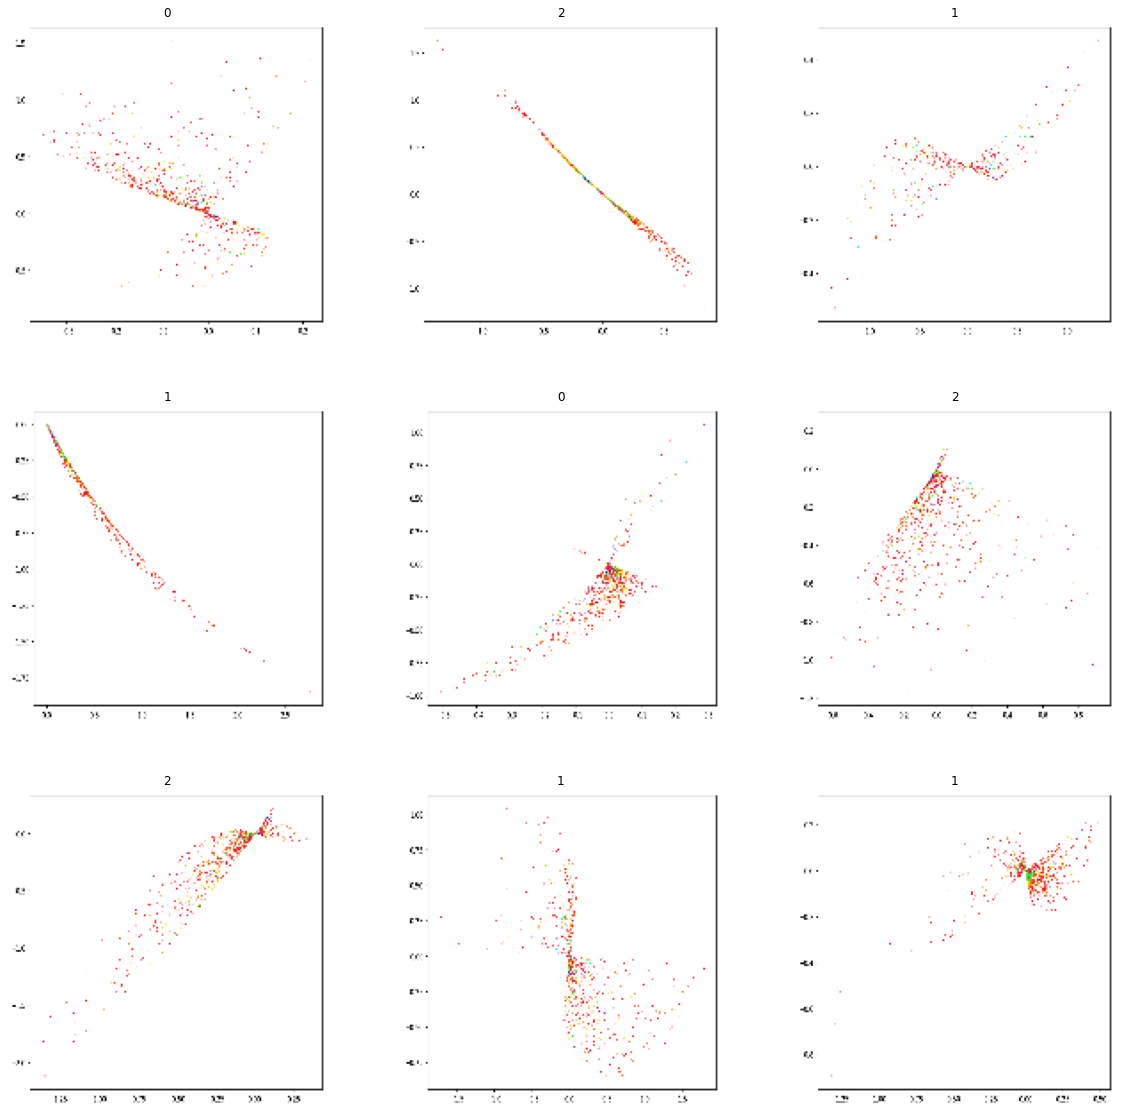

In [10]:
# labels= (0=hel_minus,1=hel_zero, 2=hel_one)

plt.figure(figsize=(20, 20))
for images, labels in data_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting. <br>
<font color="blue"> I will no do it in a first run, will try in a second run</font>

### Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [11]:
data_train = data_train.prefetch(buffer_size=32)
data_val = data_val.prefetch(buffer_size=32)

## Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs) # Will not do it in a first run

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Train Model

In [13]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_hel=model.fit(
    data_train, epochs=epochs, callbacks=callbacks, validation_data=data_val,
)

Epoch 1/50


2021-10-27 16:37:27.060786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - ETA: 0s - loss: 1.1938 - accuracy: 0.3833

2021-10-27 16:38:45.001064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-27 16:38:55.088572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 58 of 256
2021-10-27 16:39:06.152447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 125 of 256
2021-10-27 16:39:13.832982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


23/23 [==============================] - 108s 4s/step - loss: 1.1938 - accuracy: 0.3833 - val_loss: 1.0987 - val_accuracy: 0.3167
Epoch 2/50


/Users/carloscardona/miniforge3/envs/tf_m1_v1/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


23/23 [==============================] - 8s 334ms/step - loss: 1.0789 - accuracy: 0.4639 - val_loss: 1.0936 - val_accuracy: 0.3944
Epoch 3/50
23/23 [==============================] - 8s 327ms/step - loss: 1.0073 - accuracy: 0.5083 - val_loss: 1.1015 - val_accuracy: 0.3167
Epoch 4/50
23/23 [==============================] - 8s 322ms/step - loss: 0.8064 - accuracy: 0.6569 - val_loss: 1.1826 - val_accuracy: 0.3167
Epoch 5/50
23/23 [==============================] - 8s 333ms/step - loss: 0.6554 - accuracy: 0.7028 - val_loss: 1.3422 - val_accuracy: 0.3167
Epoch 6/50
23/23 [==============================] - 8s 330ms/step - loss: 0.3789 - accuracy: 0.8431 - val_loss: 1.5727 - val_accuracy: 0.3167
Epoch 7/50
23/23 [==============================] - 8s 323ms/step - loss: 0.2370 - accuracy: 0.9111 - val_loss: 1.8476 - val_accuracy: 0.3167
Epoch 8/50
23/23 [==============================] - 8s 324ms/step - loss: 0.2181 - accuracy: 0.9306 - val_loss: 1.8557 - val_accuracy: 0.3167
Epoch 9/50
23/23 

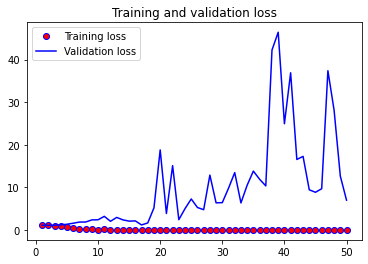

In [14]:

loss_cat = history_hel.history['loss']
val_loss_cat = history_hel.history['val_loss']

epochs = range(1, len(loss_cat) + 1)

plt.figure()

plt.plot(epochs, loss_cat, 'bo', label='Training loss', markerfacecolor='red')
plt.plot(epochs, val_loss_cat, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<font color = 'blue'>Now we can take load the last saved epoch and make preditions with it  </font>

In [12]:
#model_last.save("save_at_28.h5")
#load the model from h5 file
from numpy import loadtxt
from keras.models import load_model
 
# load model
model_last = load_model("save_at_50.h5")
# summarize model.
model_last.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 32)   128         conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
image_unseen_path=r"data/unseen_images/"
# lets take a hel_minus image
img = keras.preprocessing.image.load_img(
    image_unseen_path+"/hel_minus/jetskyimg_10.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_last.predict(img_array)

#print( "This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score) )
print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
      % (predictions[0][0], predictions[0][1], predictions[0][2]) )

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [15]:
import glob
import os

import pandas as pd
import numpy as np

all_minus = glob.glob(image_unseen_path + "hel_minus/*.png")
all_zero = glob.glob(image_unseen_path + "hel_zero/*.png")
all_plus = glob.glob(image_unseen_path + "hel_plus/*.png")

NameError: name 'image_unseen_path' is not defined

In [21]:
print("For a sample of unseen minus helicities we have")
for file in all_minus[:10]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_last.predict(img_array)
    print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
          % (predictions[0][0], predictions[0][1], predictions[0][2]) )

For a sample of unseen minus helicities we have
The propability of being a minus= 6.6846755e-05, a zero = 5.5553334e-10, and a plus = 0.9999331
The propability of being a minus= 0.3312441, a zero = 3.2661924e-07, and a plus = 0.6687556
The propability of being a minus= 0.99635786, a zero = 2.0618948e-11, and a plus = 0.0036420655
The propability of being a minus= 0.92901355, a zero = 6.426939e-10, and a plus = 0.07098642
The propability of being a minus= 0.96157265, a zero = 3.335439e-08, and a plus = 0.038427312
The propability of being a minus= 0.99765944, a zero = 9.11398e-07, and a plus = 0.0023396083
The propability of being a minus= 0.99671257, a zero = 2.2342986e-08, and a plus = 0.0032874595
The propability of being a minus= 0.9999994, a zero = 4.4746335e-14, and a plus = 6.0072864e-07
The propability of being a minus= 0.9983255, a zero = 0.0003937158, and a plus = 0.0012807419
The propability of being a minus= 0.011733969, a zero = 1.073e-08, and a plus = 0.98826605


In [23]:
print("For a sample of unseen plus helicities we have")
for file in all_plus[:10]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_last.predict(img_array)
    #print( "This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score) )
    print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
          % (predictions[0][0], predictions[0][1], predictions[0][2]) )

For a sample of unseen plus helicities we have
The propability of being a minus= 0.05322227, a zero = 6.597657e-09, and a plus = 0.94677776
The propability of being a minus= 0.0034950245, a zero = 7.746999e-06, and a plus = 0.9964972
The propability of being a minus= 0.3359701, a zero = 8.5806984e-10, and a plus = 0.6640299
The propability of being a minus= 0.98533, a zero = 2.2536929e-11, and a plus = 0.014670016
The propability of being a minus= 0.5317924, a zero = 9.195129e-11, and a plus = 0.46820766
The propability of being a minus= 0.6462058, a zero = 1.5516423e-05, and a plus = 0.35377872
The propability of being a minus= 0.44767877, a zero = 2.9948353e-09, and a plus = 0.5523212
The propability of being a minus= 1.0, a zero = 6.281315e-12, and a plus = 1.602381e-08
The propability of being a minus= 5.3207314e-05, a zero = 0.0007136315, and a plus = 0.9992331
The propability of being a minus= 1.0, a zero = 1.1344321e-09, and a plus = 6.63436e-10


In [24]:
print("For a sample of unseen zero helicities we have")
for file in all_zero[:10]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_last.predict(img_array)
    #print( "This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score) )
    print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
          % (predictions[0][0], predictions[0][1], predictions[0][2]) )

For a sample of unseen zero helicities we have
The propability of being a minus= 0.012257934, a zero = 0.0031547423, and a plus = 0.9845873
The propability of being a minus= 0.011164884, a zero = 0.0010137114, and a plus = 0.9878214
The propability of being a minus= 0.047099505, a zero = 0.00031940057, and a plus = 0.95258105
The propability of being a minus= 0.12206828, a zero = 9.138385e-08, and a plus = 0.87793165
The propability of being a minus= 1.0, a zero = 2.6845812e-10, and a plus = 1.4204129e-09
The propability of being a minus= 0.017516268, a zero = 2.4375567e-13, and a plus = 0.9824837
The propability of being a minus= 1.0, a zero = 3.4107746e-09, and a plus = 2.7941207e-11
The propability of being a minus= 0.0014925459, a zero = 2.9739727e-08, and a plus = 0.99850744
The propability of being a minus= 0.04618573, a zero = 2.49282e-05, and a plus = 0.95378935
The propability of being a minus= 0.00030993286, a zero = 0.00017998232, and a plus = 0.99951005


### We can check other epochs, lets see epoch = 10

In [25]:
# load model
model_10 = load_model("save_at_10.h5")
# summarize model.
model_10.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 32)   128         conv2d[0][0]                     
______________________________________________________________________________________________

In [26]:
print("For a sample of unseen minus helicities we have")
for file in all_minus[:10]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_10.predict(img_array)
    #print( "This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score) )
    print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
          % (predictions[0][0], predictions[0][1], predictions[0][2]) )

For a sample of unseen minus helicities we have
The propability of being a minus= 0.04300573, a zero = 0.21079971, and a plus = 0.74619454
The propability of being a minus= 0.048774894, a zero = 0.24707069, and a plus = 0.70415443
The propability of being a minus= 0.055853873, a zero = 0.23400791, and a plus = 0.71013826
The propability of being a minus= 0.049350295, a zero = 0.23803459, and a plus = 0.7126151
The propability of being a minus= 0.047165815, a zero = 0.23252895, and a plus = 0.7203052
The propability of being a minus= 0.052298367, a zero = 0.24195503, and a plus = 0.70574653
The propability of being a minus= 0.050876137, a zero = 0.2608915, and a plus = 0.68823236
The propability of being a minus= 0.052355707, a zero = 0.24331936, and a plus = 0.7043249
The propability of being a minus= 0.048089843, a zero = 0.24210286, and a plus = 0.70980734
The propability of being a minus= 0.050751697, a zero = 0.23234566, and a plus = 0.7169027


In [27]:
print("For a sample of unseen plus helicities we have")
for file in all_plus[:10]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_10.predict(img_array)
    print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
          % (predictions[0][0], predictions[0][1], predictions[0][2]) )

For a sample of unseen plus helicities we have
The propability of being a minus= 0.049708627, a zero = 0.22668421, and a plus = 0.7236071
The propability of being a minus= 0.052849673, a zero = 0.23973311, and a plus = 0.70741725
The propability of being a minus= 0.04587905, a zero = 0.20211993, and a plus = 0.75200105
The propability of being a minus= 0.045514267, a zero = 0.21429804, and a plus = 0.7401877
The propability of being a minus= 0.041078784, a zero = 0.19679031, and a plus = 0.7621309
The propability of being a minus= 0.05651937, a zero = 0.26636556, and a plus = 0.6771151
The propability of being a minus= 0.05015882, a zero = 0.2279023, and a plus = 0.7219389
The propability of being a minus= 0.052772146, a zero = 0.25748664, and a plus = 0.68974125
The propability of being a minus= 0.04987398, a zero = 0.23829712, and a plus = 0.7118289
The propability of being a minus= 0.0480856, a zero = 0.21960565, and a plus = 0.7323087


In [28]:
print("For a sample of unseen zero helicities we have")
for file in all_zero[:10]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_10.predict(img_array)
    print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
          % (predictions[0][0], predictions[0][1], predictions[0][2]) )

For a sample of unseen zero helicities we have
The propability of being a minus= 0.046307612, a zero = 0.22868983, and a plus = 0.7250025
The propability of being a minus= 0.04791453, a zero = 0.23250782, and a plus = 0.7195777
The propability of being a minus= 0.0552917, a zero = 0.254392, and a plus = 0.69031626
The propability of being a minus= 0.04936084, a zero = 0.21852395, and a plus = 0.7321152
The propability of being a minus= 0.049899403, a zero = 0.24950975, and a plus = 0.7005908
The propability of being a minus= 0.046799645, a zero = 0.1995566, and a plus = 0.75364375
The propability of being a minus= 0.056302913, a zero = 0.2870359, and a plus = 0.65666115
The propability of being a minus= 0.05000724, a zero = 0.22713976, and a plus = 0.722853
The propability of being a minus= 0.042203367, a zero = 0.20960705, and a plus = 0.74818957
The propability of being a minus= 0.050667565, a zero = 0.24965298, and a plus = 0.69967943


### Now lets look into the whole 100 unseen samples per helicity

In [33]:
print("For a sample of 100 unseen minus helicities we have:")
positive=0
for file in all_minus:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_last.predict(img_array)
#     print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
#           % (predictions[0][0], predictions[0][1], predictions[0][2]) )
    #print(predictions[0][0])
    if predictions[0][0]>0.5:
        positive+=1
print("Out of 100 samples the CNN identify correctly %s samples" % positive)        

For a sample of 100 unseen minus helicities we have
Out of 100 the CNN identify correctly 71 samples


In [34]:
print("For a sample of 100 unseen plus helicities we have:")
positive=0
for file in all_plus:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_last.predict(img_array)
#     print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
#           % (predictions[0][0], predictions[0][1], predictions[0][2]) )
    #print(predictions[0][0])
    if predictions[0][2]>0.5:
        positive+=1
print("Out of 100 samples the CNN identify correctly %s samples" % positive)  

For a sample of 100 unseen plus helicities we have:
Out of 100 samples the CNN identify correctly 39 samples


In [35]:
print("For a sample of 100 unseen zero helicities we have:")
positive=0
for file in all_zero:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_last.predict(img_array)
#     print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
#           % (predictions[0][0], predictions[0][1], predictions[0][2]) )
    #print(predictions[0][0])
    if predictions[0][2]>0.5:
        positive+=1
print("Out of 100 samples the CNN identify correctly %s samples" % positive) 

For a sample of 100 unseen zero helicities we have:
Out of 100 samples the CNN identify correctly 49 samples


# Lets use (naive) data augmentation 

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)


In [38]:
def make_model_augment(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs) 

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model_augment = make_model_augment(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model_augment, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Train model

In [40]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_augmented_at_{epoch}.h5"),
]
model_augment.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_hel=model_augment.fit(
    data_train, epochs=epochs, callbacks=callbacks, validation_data=data_val,
)

Epoch 1/50
23/23 [==============================] - 20s 603ms/step - loss: 1.2318 - accuracy: 0.3639 - val_loss: 1.0976 - val_accuracy: 0.3944
Epoch 2/50
23/23 [==============================] - 18s 598ms/step - loss: 1.2031 - accuracy: 0.3333 - val_loss: 1.0970 - val_accuracy: 0.3944
Epoch 3/50
23/23 [==============================] - 18s 593ms/step - loss: 1.1952 - accuracy: 0.3347 - val_loss: 1.0960 - val_accuracy: 0.3944
Epoch 4/50
23/23 [==============================] - 18s 591ms/step - loss: 1.1527 - accuracy: 0.3556 - val_loss: 1.0931 - val_accuracy: 0.3944
Epoch 5/50
23/23 [==============================] - 18s 589ms/step - loss: 1.1551 - accuracy: 0.3486 - val_loss: 1.0956 - val_accuracy: 0.3944
Epoch 6/50
23/23 [==============================] - 18s 591ms/step - loss: 1.1467 - accuracy: 0.3431 - val_loss: 1.0921 - val_accuracy: 0.3944
Epoch 7/50
23/23 [==============================] - 18s 585ms/step - loss: 1.1443 - accuracy: 0.3931 - val_loss: 1.0948 - val_accuracy: 0.3944

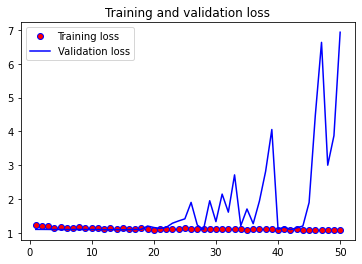

In [41]:

loss_cat = history_hel.history['loss']
val_loss_cat = history_hel.history['val_loss']

epochs = range(1, len(loss_cat) + 1)

plt.figure()

plt.plot(epochs, loss_cat, 'bo', label='Training loss', markerfacecolor='red')
plt.plot(epochs, val_loss_cat, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<font color='blue'><font size=6> Now lets train only using plus and minus helicites</font> <br><font>
I feel like the zero helicities are confusing the machine</font>

In [5]:
image_train_newpath=r"data/train_non-zeros/"
image_size = (180, 180)
batch_size = 32
interpolation="bilinear" #String, the interpolation method used when resizing images. 
# Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.
seed=1337 # Optional random seed for shuffling and transformations.

data_train_binary= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_newpath,
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=0.2,
    subset="training",
    interpolation=interpolation
)

data_val_binary= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_newpath,
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=0.2,
    subset="validation",
    interpolation=interpolation
)

Found 600 files belonging to 2 classes.
Using 480 files for training.
Found 600 files belonging to 2 classes.
Using 120 files for validation.


In [36]:
from random import sample
random_minus = sample(range(0, 299), 3)
[random_minus.index(rm) for rm in random_minus]

[0, 1, 2]

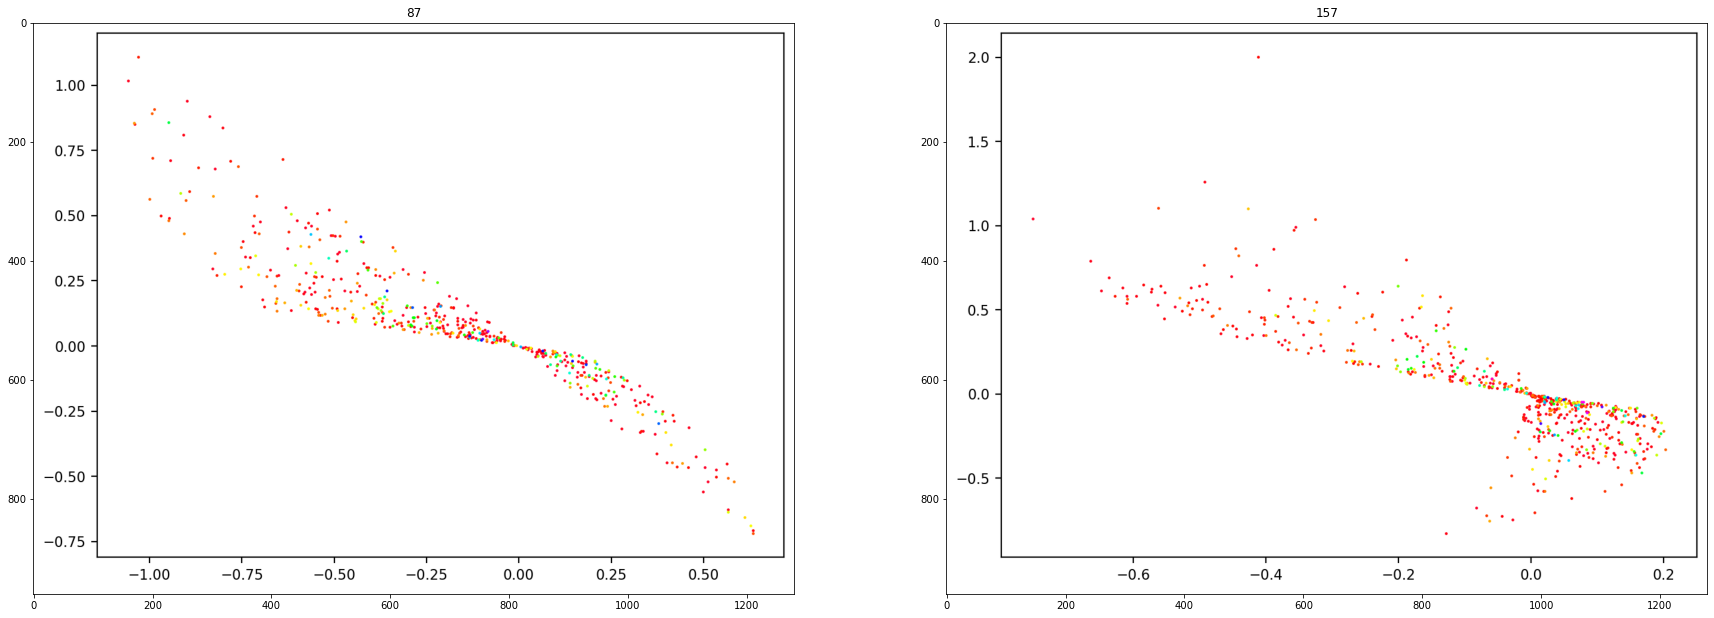

In [46]:
from random import sample
random_minus = sample(range(0, 299), 2)
random_plus = sample(range(1254, 1550), 2)

plt.figure(figsize=(30,30))
for rm in random_minus:
    ax = plt.subplot(1, 2, random_minus.index(rm) + 1)
    one_image = Image.open(image_train_newpath+"hel_minus/jetskyimg_" + str(rm)+".png", "r")
    image_array = np.array(one_image)
    plt.title(rm)
    plt.imshow(image_array)

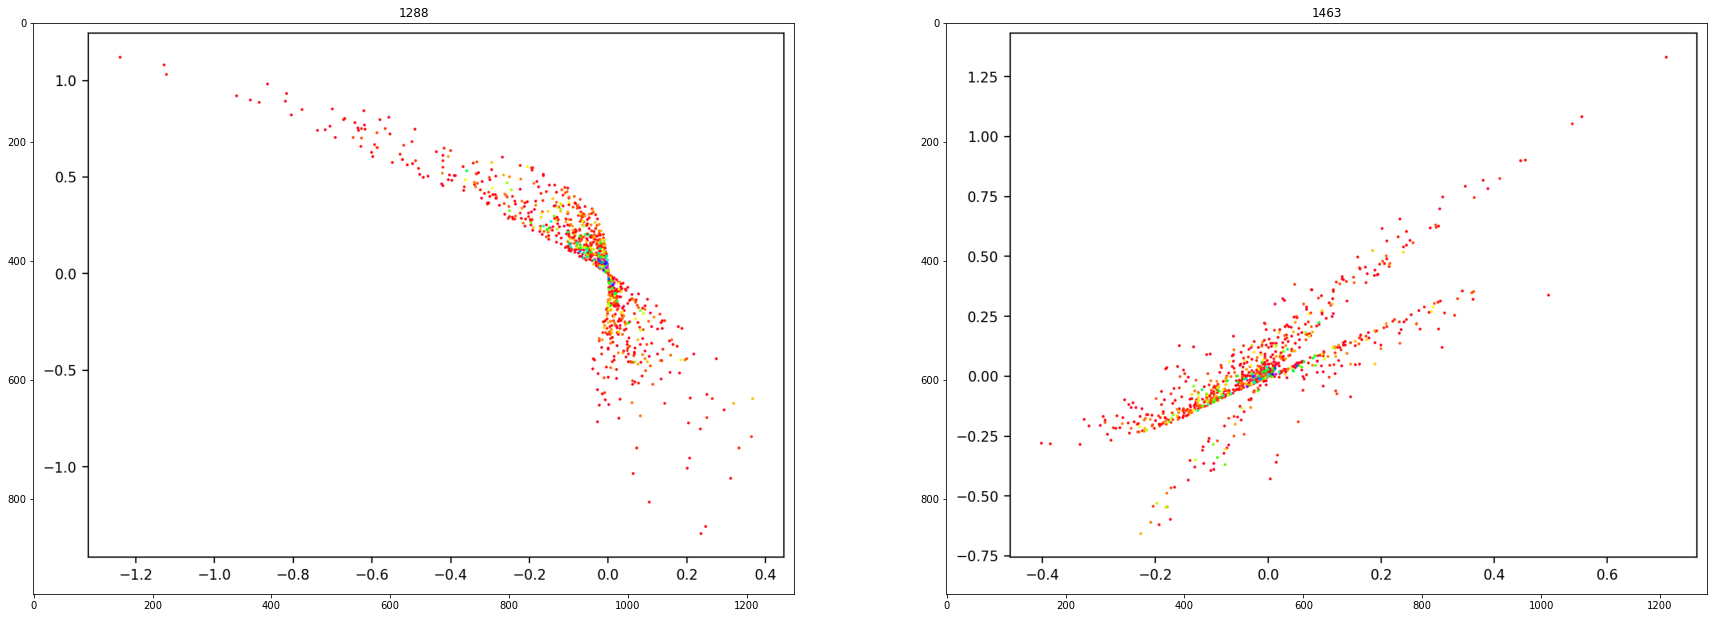

In [48]:
plt.figure(figsize=(30,30))
for rm in random_plus:
    ax = plt.subplot(1, 2, random_plus.index(rm) + 1)
    one_image = Image.open(image_train_newpath+"hel_plus/jetskyimg_" + str(rm)+".png", "r")
    image_array = np.array(one_image)
    plt.title(rm)
    plt.imshow(image_array)

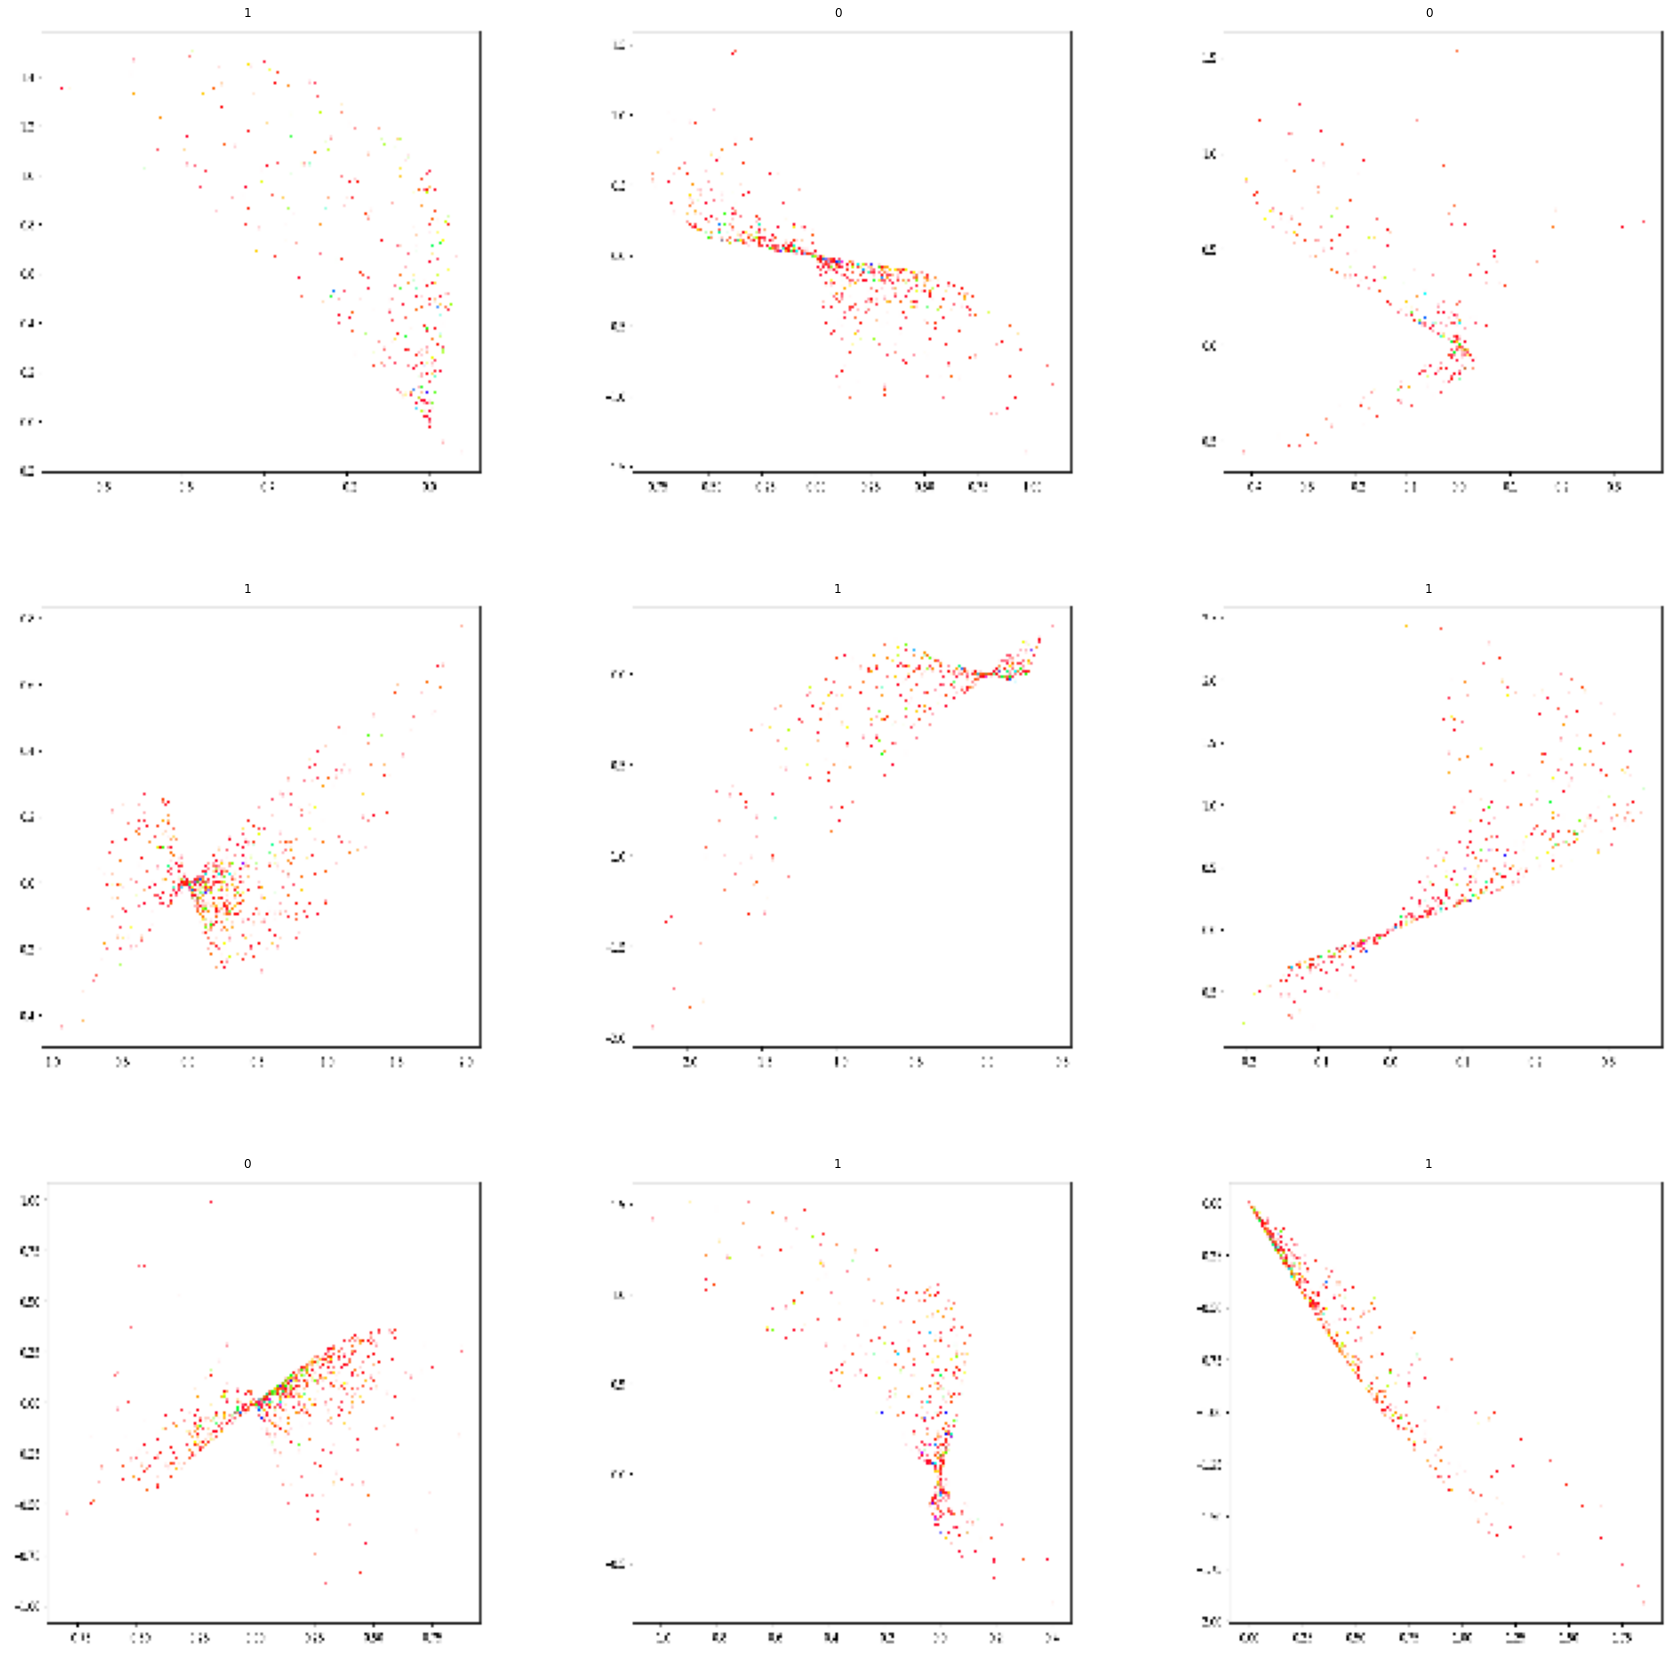

In [49]:
# labels= (0=hel_minus,1==hel_plus)

plt.figure(figsize=(30,30))
for images, labels in data_train_binary.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Make model with two classes and without image augmentation

In [50]:
data_train_binary = data_train_binary.prefetch(buffer_size=32)
data_val_binary = data_val_binary.prefetch(buffer_size=32)
model_binary = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model_binary, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Training model

In [53]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_binary_at_{epoch}.h5"),
]
model_binary.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_binary=model_binary.fit(
    data_train_binary, epochs=epochs, callbacks=callbacks, validation_data=data_val_binary,
)

Epoch 1/50
15/15 [==============================] - 14s 567ms/step - loss: 0.1235 - accuracy: 0.9521 - val_loss: 0.7611 - val_accuracy: 0.5000
Epoch 2/50
15/15 [==============================] - 12s 542ms/step - loss: 0.0959 - accuracy: 0.9521 - val_loss: 0.8123 - val_accuracy: 0.5000
Epoch 3/50
15/15 [==============================] - 12s 544ms/step - loss: 0.0791 - accuracy: 0.9729 - val_loss: 1.1237 - val_accuracy: 0.5000
Epoch 4/50
15/15 [==============================] - 12s 539ms/step - loss: 0.0962 - accuracy: 0.9500 - val_loss: 1.4078 - val_accuracy: 0.5000
Epoch 5/50
15/15 [==============================] - 12s 540ms/step - loss: 0.0316 - accuracy: 0.9917 - val_loss: 1.4174 - val_accuracy: 0.5000
Epoch 6/50
15/15 [==============================] - 12s 543ms/step - loss: 0.0242 - accuracy: 0.9917 - val_loss: 1.7627 - val_accuracy: 0.5000
Epoch 7/50
15/15 [==============================] - 13s 543ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 2.5983 - val_accuracy: 0.5000

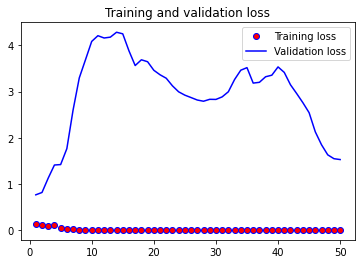

In [54]:
loss_cat = history_binary.history['loss']
val_loss_cat = history_binary.history['val_loss']

epochs = range(1, len(loss_cat) + 1)

plt.figure()

plt.plot(epochs, loss_cat, 'bo', label='Training loss', markerfacecolor='red')
plt.plot(epochs, val_loss_cat, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
print("For a sample of unseen minus helicities we have")
for file in all_minus[:10]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_binary.predict(img_array)
    score = predictions[0]
    print(
    "This image is %.2f percent minus and %.2f percent plus."
    % (100 * (1 - score), 100 * score))


For a sample of unseen minus helicities we have
This image is 2.81 percent minus and 97.19 percent plus.
This image is 97.43 percent minus and 2.57 percent plus.
This image is 99.99 percent minus and 0.01 percent plus.
This image is 98.11 percent minus and 1.89 percent plus.
This image is 98.77 percent minus and 1.23 percent plus.
This image is 0.08 percent minus and 99.92 percent plus.
This image is 98.60 percent minus and 1.40 percent plus.
This image is 100.00 percent minus and 0.00 percent plus.
This image is 48.78 percent minus and 51.22 percent plus.
This image is 0.00 percent minus and 100.00 percent plus.


In [62]:
print("For a sample of 100 unseen minus helicities we have:")
positive=0
for file in all_minus:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_binary.predict(img_array)
    score = predictions[0]

    if score < 0.5:
        positive+=1
print("Out of 100 samples the CNN identify correctly %s samples" % positive)  

For a sample of 100 unseen minus helicities we have:
Out of 100 samples the CNN identify correctly 54 samples


In [64]:
print("For a sample of 100 unseen minus helicities we have:")
positive=0
for file in all_plus:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_binary.predict(img_array)
    score = predictions[0]

    if score > 0.5:
        positive+=1
print("Out of 100 samples the CNN identify correctly %s samples" % positive)  

For a sample of 100 unseen minus helicities we have:
Out of 100 samples the CNN identify correctly 73 samples


# Now a binary model with data augmentation

In [65]:
data_train_binary = data_train_binary.prefetch(buffer_size=32)
data_val_binary = data_val_binary.prefetch(buffer_size=32)
model_binary_augment = make_model_augment(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model_binary_augment, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Train model

In [66]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_binary_at_{epoch}.h5"),
]
model_binary_augment.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_binary=model_binary_augment.fit(
    data_train_binary, epochs=epochs, callbacks=callbacks, validation_data=data_val_binary,
)

Epoch 1/50
15/15 [==============================] - 14s 569ms/step - loss: 0.7397 - accuracy: 0.5188 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/50
15/15 [==============================] - 13s 549ms/step - loss: 0.7036 - accuracy: 0.5396 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/50
15/15 [==============================] - 12s 539ms/step - loss: 0.7606 - accuracy: 0.4917 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 4/50
15/15 [==============================] - 13s 545ms/step - loss: 0.7453 - accuracy: 0.4938 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 5/50
15/15 [==============================] - 12s 541ms/step - loss: 0.7142 - accuracy: 0.5125 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 6/50
15/15 [==============================] - 12s 543ms/step - loss: 0.7170 - accuracy: 0.4938 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 7/50
15/15 [==============================] - 12s 539ms/step - loss: 0.7076 - accuracy: 0.5458 - val_loss: 0.7048 - val_accuracy: 0.5000

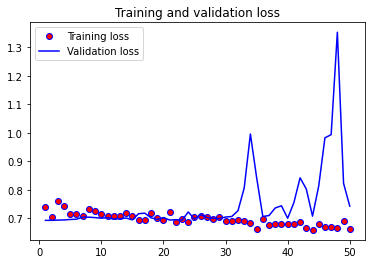

In [67]:
loss_cat = history_binary.history['loss']
val_loss_cat = history_binary.history['val_loss']

epochs = range(1, len(loss_cat) + 1)

plt.figure()

plt.plot(epochs, loss_cat, 'bo', label='Training loss', markerfacecolor='red')
plt.plot(epochs, val_loss_cat, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

It goes crazy after 30 epochs, lets use 28 then

In [68]:
#model_last.save("save_at_28.h5")
#load the model from h5 file
from numpy import loadtxt
from keras.models import load_model
 
# load model
model_28 = load_model("save_binary_at_28.h5")
# summarize model.
model_28.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 90, 90, 32)   896         rescaling_6[0][0]                
____________________________________________________________________________________________

In [70]:
print("For a sample of 100 unseen minus helicities we have:")
positive=0
for file in all_minus:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_28.predict(img_array)
    score = predictions[0]

    if score > 0.5:
        positive+=1
print("Out of 100 samples the CNN identify correctly %s samples" % positive)  

For a sample of 100 unseen minus helicities we have:
Out of 100 samples the CNN identify correctly 100 samples


In [71]:
print("For a sample of 100 unseen minus helicities we have:")
positive=0
for file in all_plus:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_28.predict(img_array)
    score = predictions[0]

    if score < 0.5:
        positive+=1
print("Out of 100 samples the CNN identify correctly %s samples" % positive)  

For a sample of 100 unseen minus helicities we have:
Out of 100 samples the CNN identify correctly 0 samples


In [73]:
image_unseen_path=r"data/unseen_images/"
# lets take a hel_minus image
img = keras.preprocessing.image.load_img(
    image_unseen_path+"/hel_minus/jetskyimg_10.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_28.predict(img_array)
predictions[0]
# #print( "This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score) )
# print( "The propability of being a minus= %s, a zero = %s, and a plus = %s" 
#       % (predictions[0][0], predictions[0][1], predictions[0][2]) )

array([0.5595623], dtype=float32)

In [75]:
print("For a sample of 100 unseen minus helicities we have:")
positive=0
for file in all_plus[:20]:
    img = keras.preprocessing.image.load_img(file, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model_28.predict(img_array)
    print(predictions)

For a sample of 100 unseen minus helicities we have:
[[0.56023306]]
[[0.5605756]]
[[0.56068593]]
[[0.5583751]]
[[0.5597719]]
[[0.5764525]]
[[0.56030184]]
[[0.560481]]
[[0.55974376]]
[[0.5577819]]
[[0.5586306]]
[[0.56152457]]
[[0.55932945]]
[[0.5593053]]
[[0.56098825]]
[[0.5605569]]
[[0.5612488]]
[[0.5608705]]
[[0.5591571]]
[[0.560922]]


Data augmentation is not a good idea here.